In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import numpy as np
import os
import sys
import pennylane as qml
from pennylane import numpy as pnp
import torch
import torch.nn as nn
import matplotlib
import shutil
import matplotlib.pyplot as plt
from math import pi

In [ ]:
from src.nn.DVPDESolver import DVPDESolver
from src.nn.CVPDESolver import CVPDESolver
from src.utils.logger import Logging
from src.nn.pde import wave_operator
from src.utils.plot_prediction import plt_prediction
from src.data.wave_dataset import u, r
from src.data.wave_dataset import Sampler

In [11]:
log_path = "./testing_checkpoints"
logger = Logging(log_path)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
torch.cuda.is_available()

True

## Generate Testing Dataset


In [ ]:
a = torch.tensor(0.5, dtype=torch.float32, device=DEVICE)
c = torch.tensor(2.0, dtype=torch.float32, device=DEVICE)

# Domain boundaries - convert to float32
ics_coords = np.array([[0.0, 0.0], [0.0, 1.0]], dtype=np.float32)
bc1_coords = np.array([[0.0, 0.0], [1.0, 0.0]], dtype=np.float32)
bc2_coords = np.array([[0.0, 1.0], [1.0, 1.0]], dtype=np.float32)
dom_coords = np.array([[0.0, 0.0], [1.0, 1.0]], dtype=np.float32)

# Create initial conditions samplers
ics_sampler = Sampler(2, ics_coords, lambda x: u(x, a, c), device=DEVICE)

# Create boundary conditions samplers
bc1 = Sampler(2, bc1_coords, lambda x: u(x, a, c), device=DEVICE)
bc2 = Sampler(2, bc2_coords, lambda x: u(x, a, c), device=DEVICE)
bcs_sampler = [bc1, bc2]

# Create residual sampler
res_sampler = Sampler(2, dom_coords, lambda x: r(x, a, c), device=DEVICE)
coll_sampler = Sampler(2, dom_coords, lambda x: u(x, a, c), device=DEVICE)

# Create mesh grid with float32
nn = 30
t = np.linspace(dom_coords[0, 0], dom_coords[1, 0], nn, dtype=np.float32)[:, None]
x = np.linspace(dom_coords[0, 1], dom_coords[1, 1], nn, dtype=np.float32)[:, None]
t, x = np.meshgrid(t, x)

# Convert to PyTorch tensor with float32
X_star = (
    torch.hstack(
        (torch.from_numpy(t.flatten()[:, None]), torch.from_numpy(x.flatten()[:, None]))
    )
    .to(DEVICE)
    .to(torch.float32)
)


u_star = u(X_star, a, c)
f_star = r(X_star, a, c)

# Load trained model


In [ ]:
model_dir = "./models/2025-02-21_11-27-26-796633"  # circ_19

In [ ]:
data = X_star

model_path = os.path.join(model_dir, "model.pth")
state = DVPDESolver.load_state(model_path)
solver = state["args"]["solver"]

if solver == "CV":
    state = CVPDESolver.load_state(model_path)
    model = CVPDESolver(state["args"], logger, data, DEVICE)

    model.preprocessor.load_state_dict(state["preprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])
    model.postprocessor.load_state_dict(state["postprocessor"])

elif solver == "Classical":
    state = ClassicalSolver.load_state(model_path)

    if "hidden_network" in state:
        from src.nn.ClassicalSolver2 import ClassicalSolver2

        state = ClassicalSolver2.load_state(model_path)
        model = ClassicalSolver2(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.hidden.load_state_dict(state["hidden_network"])
        model.postprocessor.load_state_dict(state["postprocessor"])

    else:
        from src.nn.ClassicalSolver import ClassicalSolver

        model = ClassicalSolver(state["args"], logger, data, DEVICE)
        model.preprocessor.load_state_dict(state["preprocessor"])
        model.postprocessor.load_state_dict(state["postprocessor"])

else:
    state = DVPDESolver.load_state(model_path)
    model = DVPDESolver(state["args"], logger, data, DEVICE)
    model.preprocessor.load_state_dict(state["preprocessor"])
    model.postprocessor.load_state_dict(state["postprocessor"])
    model.quantum_layer.load_state_dict(state["quantum_layer"])


model.logger = logger
model.logger.print(f"The settings used: {model.args}")
for key, value in model.args.items():
    model.logger.print(f"{key} : {value}")

model.logger.print(f"Totoal number of iterations : {len(state['loss_history'])}")
model.logger.print(f"The final loss : {state['loss_history'][-1]}")

model.loss_history = state["loss_history"]
model.model_path = logger.get_output_dir()


# Print total number of parameters
total_params = sum(p.numel() for p in model.parameters())
model.logger.print(f"Total number of parameters: {total_params}")
shutil.copytree(
    model_dir,
    os.path.join(logger.get_output_dir(), model_dir.split("/")[-1]),
    dirs_exist_ok=True,
)

INFO:src.utils.logger:The settings used: {'batch_size': 64, 'epochs': 20000, 'lr': 0.0001, 'seed': 1, 'print_every': 100, 'log_path': './checkpoints/wave', 'input_dim': 2, 'output_dim': 1, 'num_qubits': 5, 'hidden_dim': 50, 'num_quantum_layers': 1, 'classic_network': [2, 50, 1], 'q_ansatz': 'sim_circ_19', 'mode': 'hybrid', 'activation': 'tanh', 'shots': None, 'problem': 'wave', 'solver': 'DV', 'device': 'cpu', 'method': 'None', 'cutoff_dim': 20, 'class': 'DV', 'encoding': 'angle'}
INFO:src.utils.logger:batch_size : 64
INFO:src.utils.logger:epochs : 20000
INFO:src.utils.logger:lr : 0.0001
INFO:src.utils.logger:seed : 1
INFO:src.utils.logger:print_every : 100
INFO:src.utils.logger:log_path : ./checkpoints/wave
INFO:src.utils.logger:input_dim : 2
INFO:src.utils.logger:output_dim : 1
INFO:src.utils.logger:num_qubits : 5
INFO:src.utils.logger:hidden_dim : 50
INFO:src.utils.logger:num_quantum_layers : 1
INFO:src.utils.logger:classic_network : [2, 50, 1]
INFO:src.utils.logger:q_ansatz : sim_c

Model state loaded from ./models/2025-02-21_11-27-26-796633/model.pth
Model state loaded from ./models/2025-02-21_11-27-26-796633/model.pth


'./testing_checkpoints/2025-04-26_12-14-38-378284/2025-02-21_11-27-26-796633'

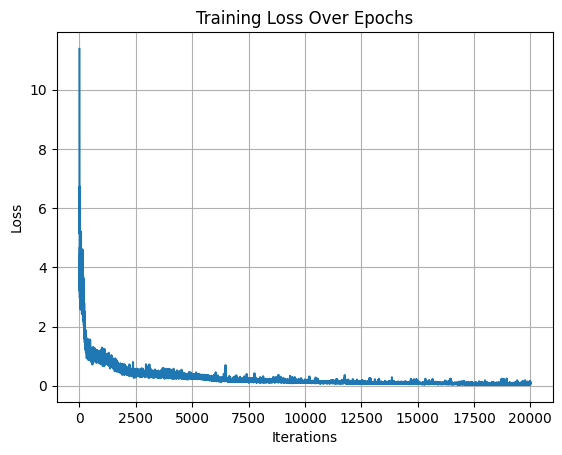

In [19]:
n = len(model.loss_history)  # Number of last iterations to plot
plt.plot(range(len(model.loss_history[-n:])), model.loss_history[-n:])
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()

file_path = os.path.join(model.log_path, "loss_history.pdf")
plt.savefig(file_path, bbox_inches="tight")
plt.show()

plt.close(
    "all",
)

In [ ]:
# Predictions
u_pred_star, f_pred_star = wave_operator(model, X_star[:, 0:1], X_star[:, 1:2])

u_pred = u_pred_star.cpu().detach().numpy()
f_pred = f_pred_star.cpu().detach().numpy()
u_star = u_star.cpu().detach().numpy()
f_star = f_star.cpu().detach().numpy()
X = X_star.cpu().detach().numpy()


# Relative L2 error
error_u = np.linalg.norm(u_pred - u_star) / np.linalg.norm(u_star) * 100
error_f = np.linalg.norm(f_pred - f_star) / np.linalg.norm(f_star) * 100

logger.print("Relative L2 error_u: {:.2e}".format(error_u))
logger.print("Relative L2 error_f: {:.2e}".format(error_f))

INFO:src.utils.logger:The circuit used in the study:


The circuit is saved in ./testing_checkpoints/2025-04-26_12-14-38-378284


In [ ]:
# Plot predictions
plt_prediction(
    logger,
    X,
    u_star,
    u_pred,
    f_star,
    f_pred,
)

### OR Simply call the python script

```bash
python -m src.contour_plots.wave_hybrid_plotting
```


In [ ]:
run -m src.contour_plots.wave_hybrid_plotting

INFO:src.utils.logger:checkpoint path: self.log_path='testing_checkpoints/wave/2025-03-08_00-42-48-247745'
INFO:src.utils.logger:Using classical Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.035788170993328094
INFO:src.utils.logger:Relative L2 error_u: 8.37e+00


INFO:src.utils.logger:Total number of parameters: 2751
INFO:src.utils.logger:Using DV Solver
INFO:src.utils.logger:Total number of iterations : 20001
INFO:src.utils.logger:The final loss : 0.12525874376296997
INFO:src.utils.logger:The circuit used in the study:


Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/wave/2025-02-24_20-00-46-837506/model.pth
Model state loaded from /okyanus/users/afarea/afrah/code/QNN4PDEs/log_files/checkpoints/wave/2025-02-21_11-27-26-796633/model.pth
The circuit is saved in testing_checkpoints/wave/2025-03-08_00-42-48-247745
